## PROBLEM :

You roll 100 dice, you then remove the sets of {1,2,3,4,5,6}. What is the expected value of the sum of the dice that are leftover?

## BEGIN WITH SIMULATION

I will use this to come up with an inital 'guess' that I can use to evaluate further work.

In [2]:
# IMPORTS
import random
import matplotlib.pyplot as plt
from collections import Counter
from mpmath import mp, mpf, nstr
import itertools
from itertools import product
mp.dps = 50  # set decimal places for mpmath calculations

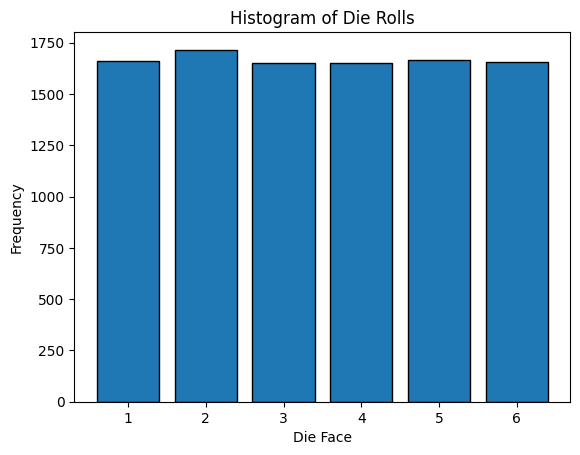

In [3]:
# I begin by creating a function that genertaes n random integers between 1 and 6
# This simulates throwing n dice

def generate_ints(n):
    numbers = []
    for _ in range(n):
        number = random.randint(1, 6)
        numbers.append(number)
    return numbers

rolls = generate_ints(10000)

plt.hist(rolls, bins=range(1, 8), align='left', rwidth=0.8, edgecolor='black')
plt.xlabel("Die Face")
plt.ylabel("Frequency")
plt.title("Histogram of Die Rolls")
plt.xticks(range(1, 7))
plt.show()

In [4]:
# Now I create a function that counts how many complete sets of 1-6 are in the generated throws
# It also returms the number of leftover dice after removing the complete sets

def count_complete_sets(rolls):
    counts = Counter(rolls)
    # A complete set is limited by the least frequent die face
    num_sets = min(counts[face] for face in range(1, 7))
    
    # Remove the sets
    for face in range(1, 7):
        counts[face] -= num_sets
    
    # Rebuild leftover list
    leftovers = []
    for face, cnt in counts.items():
        leftovers.extend([face] * cnt)
    
    return num_sets, leftovers

num_sets, leftovers = count_complete_sets(generate_ints(10000))
print(f"Number of complete sets: {num_sets}")
print(f"Leftover rolls: {len(leftovers)}")

Number of complete sets: 1644
Leftover rolls: 136


In [5]:
# I can now simulate this multiple times to get an average number of leftover dice
# and an average sum of the leftover dice

SIM_NUMBER = 50000

remaining = []
remaining_sum = []
for i in range(SIM_NUMBER):
    rolls = generate_ints(100)
    num_sets, leftovers = count_complete_sets(rolls)
    # print(f"Trial {i+1}: Number of complete sets: {num_sets}, Leftover rolls: {len(leftovers)}")
    remaining.append(len(leftovers))
    remaining_sum.append(sum(leftovers))

print(f"Average leftover rolls: {sum(remaining)/len(remaining)}")
print(f"Average sum of leftover rolls: {sum(remaining_sum)/len(remaining_sum)}")

Average leftover rolls: 29.9368
Average sum of leftover rolls: 104.82022


This gives an intial answer of ~30 dice left and a sum of ~105. This is also a good thing to see as the expected value of a roll is 3.5 so the expected sum of 30 would be 30*3.5 = 105.

I would now like to simulate how many rolls it takes to get a given number of sets. 
The expected number of rolls to get t sets.

In [6]:
# Here I create a function that simulates rolling a die until we get n complete sets of 1-6

def rolls_until_n_sets(n):
    counts = Counter()
    total_rolls = 0
    
    while True:
        roll = random.randint(1, 6)
        counts[roll] += 1
        total_rolls += 1
        
        # Check if we have at least n of each face
        if all(counts[face] >= n for face in range(1, 7)):
            return total_rolls

n = 2
trials = rolls_until_n_sets(n)
print(f"Number of rolls required for {n} complete sets:", trials)

Number of rolls required for 2 complete sets: 36


In [7]:
# Now I can simulate this multiple times to get an average number of rolls needed for n complete sets

n = 3

def n_sets_simulation(n):
    SIM_NUMBER = 10000
    counts = []

    for i in range(SIM_NUMBER):
        trials = rolls_until_n_sets(n)
        counts.append(trials)

    print(f"Average rolls needed for {n} complete sets over {SIM_NUMBER} trials: {sum(counts)/len(counts)}")
    return sum(counts)/len(counts)

average_rolls = n_sets_simulation(n)

Average rolls needed for 3 complete sets over 10000 trials: 32.5254


Average rolls needed for 0 complete sets over 10000 trials: 1.0
Average rolls needed for 1 complete sets over 10000 trials: 14.6693
Average rolls needed for 2 complete sets over 10000 trials: 24.2019
Average rolls needed for 3 complete sets over 10000 trials: 32.7764
Average rolls needed for 4 complete sets over 10000 trials: 40.7545
Average rolls needed for 5 complete sets over 10000 trials: 48.6182
Average rolls needed for 6 complete sets over 10000 trials: 56.3386
Average rolls needed for 7 complete sets over 10000 trials: 63.7966
Average rolls needed for 8 complete sets over 10000 trials: 71.4167
Average rolls needed for 9 complete sets over 10000 trials: 78.4025
Average rolls needed for 10 complete sets over 10000 trials: 85.9159
Average rolls needed for 11 complete sets over 10000 trials: 93.0604
Average rolls needed for 12 complete sets over 10000 trials: 100.3501
Average rolls needed for 13 complete sets over 10000 trials: 107.3332
Average rolls needed for 14 complete sets over

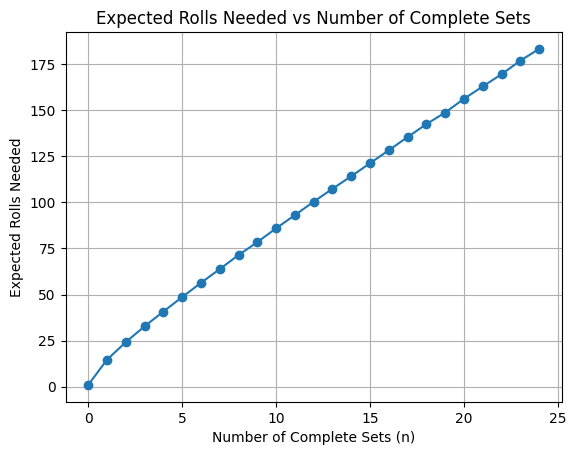

In [8]:
number_of_rolls = []
n = []
for i in range(25):
    n.append(i)
    number_of_rolls.append(n_sets_simulation(i))

plt.plot(n, number_of_rolls, marker='o')
plt.xlabel('Number of Complete Sets (n)')
plt.ylabel('Expected Rolls Needed')
plt.title('Expected Rolls Needed vs Number of Complete Sets')
plt.grid()
plt.show()


Here we see the behaviour of the expected number of rolls as the number of sets increases. It's also good to see that as n -> inf then the difference between the rolls to get n sets and n + 1 sets tends to 6. This is what I would expect.

## ANALYTICAL SOLUTION

To solve the problem analytically I solve for the expected number of sets that will apear when rolling 100 dice, I can then find the expected number of dice left over and multiply by 3.5 to find the total sum.

The analytical solution is a bit more challenging, it involes using a multinomial to count all possible ways we can have Ci counts of the ith face. All Cis then need to be constrained to be greater than the number of sets we want and then this can be put into a sum over the possible number of sets to find the expected value of the number of sets.

This involves an ordered partitions problem (compositions) which is very inefficient and the code takes a large amount of time to run.

In [11]:
def weak_compositions(n, m):
    """Generate all ordered tuples of length m summing to n (zeros allowed)."""
    if m == 1:
        yield (n,)
    else:
        for i in range(n + 1):
            for tail in weak_compositions(n - i, m - 1):
                yield (i,) + tail

# note that mpf(x) in used to convert integers to mpmath floats
# for high precision arithmetic 

n = 100     # number of dice
m = 6     # number of faces

# Precompute factorials
# this creates fact[i] = i!
fact = [mpf(1)]
for i in range(1, n+1):
    fact.append(fact[-1]*i)

def multinomial_probability(t):
    """Compute P(c_i >= t for all i) using stars-and-bars with itertools.combinations."""
    # here r in the numnber of "extra" dice after ensuring each face has at least t copies
    # are is the dice left after removal of sets
    r = n - m*t
    if r < 0:
        return mpf(0)
    
    total = mpf(0)
    
    for d in weak_compositions(r, m):
        c = [di + t for di in d]  # actual counts

        # multinomial term: n! / (c1!...cm!) * (1/m)^n
        term = fact[n]
        for ci in c:
            term /= fact[ci]
        term *= (mpf(1)/mpf(m))**n
        total += term

    return total

E_K = mpf(0)
max_t = n // m
for t in range(1, max_t+1):
    p = multinomial_probability(t)
    E_K += p
    print(f"t={t:2d}, P(all counts >= t) = {nstr(p,20)}, running E[K] = {nstr(E_K,20)}")

# Expected dice removed / remaining
removed = m * E_K
remaining = n - removed
expected_sum_remaining = remaining * mpf((m+1)/2)

print("\nFinal results:")
print("E[K] =", nstr(E_K,20))
print("Expected number of dice removed =", nstr(removed,20))
print("Expected number of dice remaining =", nstr(remaining,20))
print("Expected sum of remaining dice faces =", nstr(expected_sum_remaining,20))

t= 1, P(all counts >= t) = 0.99999992755195920241, running E[K] = 0.99999992755195920241
t= 2, P(all counts >= t) = 0.99999847859116718618, running E[K] = 1.9999984061431263886
t= 3, P(all counts >= t) = 0.99998413388305486031, running E[K] = 2.9999825400261812489
t= 4, P(all counts >= t) = 0.99989041537113996207, running E[K] = 3.999872955397321211
t= 5, P(all counts >= t) = 0.99943588946787846132, running E[K] = 4.9993088448651996723
t= 6, P(all counts >= t) = 0.99769070513906856922, running E[K] = 5.9969995500042682415
t= 7, P(all counts >= t) = 0.99216713875253459967, running E[K] = 6.9891666887568028412
t= 8, P(all counts >= t) = 0.97736167389802642333, running E[K] = 7.9665283626548292645
t= 9, P(all counts >= t) = 0.94315851866225697175, running E[K] = 8.9096868813170862363
t=10, P(all counts >= t) = 0.87447278970503543494, running E[K] = 9.7841596710221216712
t=11, P(all counts >= t) = 0.75485399472222247503, running E[K] = 10.539013665744344146
t=12, P(all counts >= t) = 0.577

It is great to see this match my eariler simulation, this makes me think that ~105 is very close to the expected value.

The above solution can also be adjusted to find the expected number of rolls to get a certain number of sets. The problem is then that this becomes a some to infinity so I can only find an aproximate value by stopping the sum early.

In [10]:
def weak_compositions(n, m):
    """Generate all ordered tuples of length m summing to n (zeros allowed)."""
    if m == 1:
        yield (n,)
    else:
        for i in range(n + 1):
            for tail in weak_compositions(n - i, m - 1):
                yield (i,) + tail

fact = [mpf(1)]
for i in range(1, 1000+1):
    fact.append(fact[-1]*i)

def multinomial_probability(t,n,m):
    """Compute P(c_i >= t for all i) using stars-and-bars with itertools.combinations."""
    # here r in the numnber of "extra" dice after ensuring each face has at least t copies
    # are is the dice left after removal of sets
    r = n - m*t
    if r < 0:
        return mpf(0)
    
    total = mpf(0)
    
    for d in weak_compositions(r, m):
        c = [di + t for di in d]  # actual counts

        # multinomial term: n! / (c1!...cm!) * (1/m)^n
        term = fact[n]
        for ci in c:
            term /= fact[ci]
        term *= (mpf(1)/mpf(m))**n
        total += term

    return total

m = 6
t = 3
E_T = mpf(m*t)

for n in range(m*t+1, 60):
    p = multinomial_probability(t,n,m)
    E_T += (1 - p)
    print(f"n={n:2d}, P(all counts >= t) = {nstr(p,20)}, running E[T] = {nstr(E_T,20)}")

print("\nFinal results:")
print("E[T] =", nstr(E_T,20))

n=19, P(all counts >= t) = 0.0064180725295908717414, running E[T] = 18.993581927470409128
n=20, P(all counts >= t) = 0.017649699456374897289, running E[T] = 19.975932228014034231
n=21, P(all counts >= t) = 0.03681477714890319485, running E[T] = 20.939117450865131036
n=22, P(all counts >= t) = 0.064654280994706654999, running E[T] = 21.874463169870424381
n=23, P(all counts >= t) = 0.10089846995358762897, running E[T] = 22.773564699916836752
n=24, P(all counts >= t) = 0.14449497911350172833, running E[T] = 23.629069720803335024
n=25, P(all counts >= t) = 0.19390751744087804909, running E[T] = 24.435162203362456975
n=26, P(all counts >= t) = 0.2473948274929386115, running E[T] = 25.187767375869518363
n=27, P(all counts >= t) = 0.30322738915513118592, running E[T] = 25.884539986714387177
n=28, P(all counts >= t) = 0.35983205455667234998, running E[T] = 26.524707932157714827
n=29, P(all counts >= t) = 0.41587248373911205089, running E[T] = 27.108835448418602776
n=30, P(all counts >= t) = 0.

I realise The analytical solutions could probably be rephrased for faster computaion but I prefer to keep them in this form as for me it is easier t understand how they work.